### Moive Recommendation System
In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [3]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

## Part1: Data ETL and Data Exploration

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [6]:
movies = spark.read.load("/FileStore/tables/movies.csv", format='csv', header = True)
ratings = spark.read.load("/FileStore/tables/ratings.csv", format='csv', header = True)
links = spark.read.load("/FileStore/tables/links.csv", format='csv', header = True)
tags = spark.read.load("/FileStore/tables/tags.csv", format='csv', header = True)

In [7]:
movies.show(5)

+------------------+-------------------+--------------------+
 _c0| _c1| _c2|
+------------------+-------------------+--------------------+
32.834666329999997|-96.586198850000002| Free @YungNupidd|
 29.95409497|-90.069414399999999|Krystal burger is...|
33.232656030000001|-96.644127530000006| @CarterBehrens 8th|
+------------------+-------------------+--------------------+
only showing top 3 rows

In [8]:
ratings.show(5)

+------+-------+------+---------+
userId|movieId|rating|timestamp|
+------+-------+------+---------+
 1| 1| 4.0|964982703|
 1| 3| 4.0|964981247|
 1| 6| 4.0|964982224|
 1| 47| 5.0|964983815|
 1| 50| 5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

In [9]:
print('Distinct values of ratings:')
print (sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
[u'0.5', u'1.0', u'1.5', u'2.0', u'2.5', u'3.0', u'3.5', u'4.0', u'4.5', u'5.0']

In [10]:
# tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
# tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
# print('For the users that rated movies and the movies that were rated:')
# print('Minimum number of ratings per user is {}'.format(tmp1))
# print('Minimum number of ratings per movie is {}'.format(tmp2))

#new solution
q1_result = ratings.groupBy('userID').count().orderBy('count', ascending=True)
tmp1 = q1_result.select('count').collect()[0]['count']
q2_result = ratings.groupBy('movieId').count().orderBy('count', ascending=True)
tmp2 = q2_result.select('count').collect()[0]['count']
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1

In [11]:
# tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
# tmp2 = ratings.select('movieId').distinct().count()
# print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))
# tmp1 = q2_result.filter(q2_result.count == 1)

#new solution
count_result = q2_result.filter(q2_result['count'] == 1).count()
distinct_movieID = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(count_result, distinct_movieID))

3446 out of 9724 movies are rated by only one user

## Part 1: Spark SQL and OLAP

### 1.1: The number of Users

In [14]:
usersNum = ratings.select("userID").distinct().count()
print('Number of users: ', usersNum)

('Number of users: ', 610)

### 1.2: The number of Movies

In [16]:
moviesNum = movies.select("movieId").distinct().count()
print('Number of movies: ', moviesNum)

('Number of movies: ', 9742)

### 1.3:  Count movies rated by users and those not rated before

In [18]:
moviesRated = ratings.select("movieId").distinct().collect()
moviesRatedNum = ratings.select("movieId").distinct().count()
moviesTotal = movies.select("movieId").distinct().collect()
print('Number of movies rated by users: ', moviesRatedNum)
print('Number of movies not rated before: ', (moviesNum - moviesRatedNum))
print('Movies not rated before are: ')
for movie in moviesTotal:
  if movie not in moviesRated:
    print(movie)

('Number of movies rated by users: ', 9724)
('Number of movies not rated before: ', 18)
Movies not rated before are: 
Row(movieId=u'5721')
Row(movieId=u'26085')
Row(movieId=u'1076')
Row(movieId=u'3338')
Row(movieId=u'8765')
Row(movieId=u'6668')
Row(movieId=u'7020')
Row(movieId=u'32160')
Row(movieId=u'3456')
Row(movieId=u'4194')
Row(movieId=u'30892')
Row(movieId=u'2939')
Row(movieId=u'7792')
Row(movieId=u'34482')
Row(movieId=u'32371')
Row(movieId=u'6849')
Row(movieId=u'25855')
Row(movieId=u'85565')

### 1.4: List Movie Genres

In [20]:
# from collections import OrderedDict
# tmp = movies.select("movieId","title","genres").toPandas()
# tmp['genres'] = tmp['genres'].str.split('|')
# # movies.select("genres").str.split('|')
# # tmp.registerTempTable("tmplist")
# genresList = []
# for row in tmp['genres']:
#   for st in row:
#     if st not in genresList:
#       genresList.append(st)  
# genresList

#new solution
from collections import OrderedDict
import pyspark.sql.functions as f
from pyspark.sql.functions import explode
tmp = movies.select("movieId","title","genres")
split_col = f.split(tmp['genres'], '\\|')
tmp = tmp.withColumn('split_col', split_col)
genresList = tmp.withColumn("split_col", explode(tmp.split_col)).select("split_col").distinct().collect()
genresList=[r['split_col'] for r in genresList]
genresList

Out[ 72 ]: 
[u'Crime',
 u'Romance',
 u'Thriller',
 u'Adventure',
 u'Drama',
 u'War',
 u'Documentary',
 u'Fantasy',
 u'Mystery',
 u'Musical',
 u'Animation',
 u'Film-Noir',
 u'(no genres listed)',
 u'IMAX',
 u'Horror',
 u'Western',
 u'Comedy',
 u'Children',
 u'Action',
 u'Sci-Fi']

### 1.5: Summarize Movies for Each Category

In [22]:
# for genre in genresList:
#   mask = tmp['genres'].apply(lambda x: genre in x)
#   df1 = tmp[mask]
#   print (genre + ':')
#   print (df1['movieId'].tolist())

#new solution
from pyspark.sql.functions import array_contains

for genre in genresList:
  df1 = tmp.filter(array_contains(tmp.split_col, genre))
  print (genre + ':')
  df1.show()

Crime:
+-------+--------------------+--------------------+--------------------+
movieId| title| genres| split_col|
+-------+--------------------+--------------------+--------------------+
 6| Heat (1995)|Action|Crime|Thri...|[Action, Crime, T...|
 16| Casino (1995)| Crime|Drama| [Crime, Drama]|
 20| Money Train (1995)|Action|Comedy|Cri...|[Action, Comedy, ...|
 21| Get Shorty (1995)|Comedy|Crime|Thri...|[Comedy, Crime, T...|
 22| Copycat (1995)|Crime|Drama|Horro...|[Crime, Drama, Ho...|
 23| Assassins (1995)|Action|Crime|Thri...|[Action, Crime, T...|
 30|Shanghai Triad (Y...| Crime|Drama| [Crime, Drama]|
 36|Dead Man Walking ...| Crime|Drama| [Crime, Drama]|
 42|Dead Presidents (...| Action|Crime|Drama|[Action, Crime, D...|
 50|Usual Suspects, T...|Crime|Mystery|Thr...|[Crime, Mystery, ...|
 63|Don't Be a Menace...| Comedy|Crime| [Comedy, Crime]|
 78|Crossing Guard, T...|Action|Crime|Dram...|[Action, Crime, D...|
 81|Things to Do in D...| Crime|Drama|Romance|[Crime, Drama, Ro...|
 97|Hate (Haine, La) ...| Crime|Drama| [Crime, Drama]|
 101|Bottle Rocket (1996)|Adventure|Comedy|...|[Adventure, Comed...|
 111| Taxi Driver (1976)|Crime|Drama|Thriller|[Crime, Drama, Th...|
 112|Rumble in the Bro...|Action|Adventure|...|[Action, Adventur...|
 117|Young Poisoner's ...| Crime|Drama| [Crime, Drama]|
 145| Bad Boys (1995)|Action|Comedy|Cri...|[Action, Comedy, ...|
 149| Amateur (1994)|Crime|Drama|Thriller|[Crime, Drama, Th...|
+-------+--------------------+--------------------+--------------------+
only showing top 20 rows

Romance:
+-------+--------------------+--------------------+--------------------+
movieId| title| genres| split_col|
+-------+--------------------+--------------------+--------------------+
 3|Grumpier Old Men ...| Comedy|Romance| [Comedy, Romance]|
 4|Waiting to Exhale...|Comedy|Drama|Romance|[Comedy, Drama, R...|
 7| Sabrina (1995)| Comedy|Romance| [Comedy, Romance]|
 11|American Presiden...|Comedy|Drama|Romance|[Comedy, Drama, R...|
 15|Cutthroat Island ...|Action|Adventure|...|[Action, Adventur...|
 17|Sense and Sensibi...| Drama|Romance| [Drama, Romance]|
 25|Leaving Las Vegas...| Drama|Romance| [Drama, Romance]|
 28| Persuasion (1995)| Drama|Romance| [Drama, Romance]|
 39| Clueless (1995)| Comedy|Romance| [Comedy, Romance]|
 46|How to Make an Am...| Drama|Romance| [Drama, Romance]|
 48| Pocahontas (1995)|Animation|Childre...|[Animation, Child...|
 49|When Night Is Fal...| Drama|Romance| [Drama, Romance]|
 52|Mighty Aphrodite ...|Comedy|Drama|Romance|[Comedy, Drama, R...|
 58|Postman, The (Pos...|Comedy|Drama|Romance|[Comedy, Drama, R...|
 64|Two if by Sea (1996)| Comedy|Romance| [Comedy, Romance]|
 68|French Twist (Gaz...| Comedy|Romance| [Comedy, Romance]|
 74| Bed of Roses (1996)| Drama|Romance| [Drama, Romance]|
 81|Things to Do in D...| Crime|Drama|Romance|[Crime, Drama, Ro...|
 83|Once Upon a Time....| Drama|Romance| [Drama, Romance]|
 85|Angels and Insect...| Drama|Romance| [Drama, Romance]|
+-------+--------------------+--------------------+--------------------+
only showing top 20 rows

Thriller:
+-------+--------------------+--------------------+--------------------+
movieId| title| genres| split_col|
+-------+--------------------+--------------------+--------------------+
 6| Heat (1995)|Action|Crime|Thri...|[Action, Crime, T...|
 10| GoldenEye (1995)|Action|Adventure|...|[Action, Adventur...|
 20| Money Train (1995)|Action|Comedy|Cri...|[Action, Comedy, ...|
 21| Get Shorty (1995)|Comedy|Crime|Thri...|[Comedy, Crime, T...|
 22| Copycat (1995)|Crime|Drama|Horro...|[Crime, Drama, Ho...|
 23| Assassins (1995)|Action|Crime|Thri...|[Action, Crime, T...|
 32|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|[Mystery, Sci-Fi,...|
 45| To Die For (1995)|Comedy|Drama|Thri...|[Comedy, Drama, T...|
 47|Seven (a.k.a. Se7...| Mystery|Thriller| [Mystery, Thriller]|
 50|Usual Suspects, T...|Crime|Mystery|Thr...|[Crime, Mystery, ...|
 61|Eye for an Eye (1...| Drama|Thriller| [Drama, Thriller]|
 66|Lawnmower Man 2: ...|Actio

## Part2: Spark ALS based approach for training model
We will use an RDD-based API from [pyspark.mllib](https://spark.apache.org/docs/2.1.1/mllib-collaborative-filtering.html) to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

In [24]:
from pyspark.mllib.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [25]:
movie_rating = sc.textFile("/FileStore/tables/ratings.csv")

In [26]:
header = movie_rating.take(1)[0]
rating_data = movie_rating.filter(lambda line: line!=header).map(lambda line: line.split(",")).map(lambda tokens: (tokens[0],tokens[1],tokens[2])).cache()

In [27]:
# check three rows
rating_data.take(3)

Out[ 77 ]: [(u'1', u'1', u'4.0'), (u'1', u'3', u'4.0'), (u'1', u'6', u'4.0')]

Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [29]:
train, validation, test = rating_data.randomSplit([6,2,2],seed = 7856)

In [30]:
train.cache()

Out[ 79 ]: PythonRDD[3991] at RDD at PythonRDD.scala:51

In [31]:
validation.cache()

Out[ 80 ]: PythonRDD[3992] at RDD at PythonRDD.scala:51

In [32]:
test.cache()

Out[ 81 ]: PythonRDD[3993] at RDD at PythonRDD.scala:51

### Part 3: ALS Model Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [34]:
import itertools
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    validation_for_predict_RDD = validation_data.map(lambda x: (x[0], x[1]))
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank, reg, num in itertools.product(ranks, reg_param, num_iters):
#     for rank in ranks:
#         for reg in reg_param:
#           for num in num_iters:
              # write your approach to train ALS model
              # make prediction
              # get the rating result
              # get the RMSE
              # Build the recommendation model using ALS on the training data
      model = ALS.train(train_data, iterations=num, rank= rank, lambda_=reg) 
      # Evaluate the model by computing the RMSE on the test data
      predictions = model.predictAll(validation_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
      rates_and_preds = validation_data.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
      error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
      print ('{} latent factors, {} iterations and regularization = {}: validation RMSE is {}'.format(rank, num, reg, error))
      if error < min_error:
          min_error = error
          best_rank = rank
          best_num = num
          best_regularization = reg
          best_model = model
    print ('\nThe best model has {} latent factors, {} iterations and regularization = {}'.format(best_rank, best_num, best_regularization))
    return best_model

In [35]:
num_iterations = [10,15,20]
ranks = [6, 8, 10, 12, 14]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

import time
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors, 10 iterations and regularization = 0.05: validation RMSE is 0.975466935019
6 latent factors, 15 iterations and regularization = 0.05: validation RMSE is 0.975978160069
6 latent factors, 20 iterations and regularization = 0.05: validation RMSE is 0.972604542196
6 latent factors, 10 iterations and regularization = 0.1: validation RMSE is 0.913899415403
6 latent factors, 15 iterations and regularization = 0.1: validation RMSE is 0.913093686028
6 latent factors, 20 iterations and regularization = 0.1: validation RMSE is 0.91160256041
6 latent factors, 10 iterations and regularization = 0.2: validation RMSE is 0.896014753719
6 latent factors, 15 iterations and regularization = 0.2: validation RMSE is 0.89665184819
6 latent factors, 20 iterations and regularization = 0.2: validation RMSE is 0.8966816973
6 latent factors, 10 iterations and regularization = 0.4: validation RMSE is 0.967039773379
6 latent factors, 15 iterations and regularization = 0.4: validation RMSE is 0.966005960398
6 latent factors, 20 iterations and regularization = 0.4: validation RMSE is 0.965945202425
6 latent factors, 10 iterations and regularization = 0.8: validation RMSE is 1.18710720504
6 latent factors, 15 iterations and regularization = 0.8: validation RMSE is 1.18708344613
6 latent factors, 20 iterations and regularization = 0.8: validation RMSE is 1.18707251108
8 latent factors, 10 iterations and regularization = 0.05: validation RMSE is 0.981234245374
8 latent factors, 15 iterations and regularization = 0.05: validation RMSE is 0.989038942354
8 latent factors, 20 iterations and regularization = 0.05: validation RMSE is 0.982872526199
8 latent factors, 10 iterations and regularization = 0.1: validation RMSE is 0.91227750827
8 latent factors, 15 iterations and regularization = 0.1: validation RMSE is 0.915131188502
8 latent factors, 20 iterations and regularization = 0.1: validation RMSE is 0.915612265813
8 latent factors, 10 iterations and regularization = 0.2: validation RMSE is 0.896355657706
8 latent factors, 15 iterations and regularization = 0.2: validation RMSE is 0.895168555655
8 latent factors, 20 iterations and regularization = 0.2: validation RMSE is 0.897195058861
8 latent factors, 10 iterations and regularization = 0.4: validation RMSE is 0.96623349873
8 latent factors, 15 iterations and regularization = 0.4: validation RMSE is 0.966209296526
8 latent factors, 20 iterations and regularization = 0.4: validation RMSE is 0.966080800818
8 latent factors, 10 iterations and regularization = 0.8: validation RMSE is 1.18711447325
8 latent factors, 15 iterations and regularization = 0.8: validation RMSE is 1.18708461432
8 latent factors, 20 iterations and regularization = 0.8: validation RMSE is 1.18707226792
10 latent factors, 10 iterations and regularization = 0.05: validation RMSE is 0.998211051118
10 latent factors, 15 iterations and regularization = 0.05: validation RMSE is 0.993418402488
10 latent factors, 20 iterations and regularization = 0.05: validation RMSE is 0.984142348261
10 latent factors, 10 iterations and regularization = 0.1: validation RMSE is 0.915360849772
10 latent factors, 15 iterations and regularization = 0.1: validation RMSE is 0.920616306169
10 latent factors, 20 iterations and regularization = 0.1: validation RMSE is 0.916650912726
10 latent factors, 10 iterations and regularization = 0.2: validation RMSE is 0.897535899413
10 latent factors, 15 iterations and regularization = 0.2: validation RMSE is 0.896099913512
10 latent factors, 20 iterations and regularization = 0.2: validation RMSE is 0.896429648303
10 latent factors, 10 iterations and regularization = 0.4: validation RMSE is 0.96535637408
10 latent factors, 15 iterations and regularization = 0.4: validation RMSE is 0.965819221773
10 latent factors, 20 iterations and regularization = 0.4: validation RMSE is 0.965927612024
10 latent factors, 10 iterations and regularization = 0.8: validation RMSE is 1.18710398814
10 latent factors, 15 iterations and

In [36]:
import matplotlib.pyplot as plt
def plot_learning_curve(iter_array, train_data, validation_data, reg, rank):
  validation_for_predict_RDD = validation_data.map(lambda x: (x[0], x[1]))
  errors = []
  for num_iters in iter_array:
    model = ALS.train(train_data, iterations=num_iters, rank= rank, lambda_=reg) 
    # Evaluate the model by computing the RMSE on the test data
    predictions = model.predictAll(validation_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = validation_data.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
    error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    errors.append(error)
  fig = plt.figure()
  ax = plt.axes()
  ax.plot(iter_array, errors);
  display(fig)

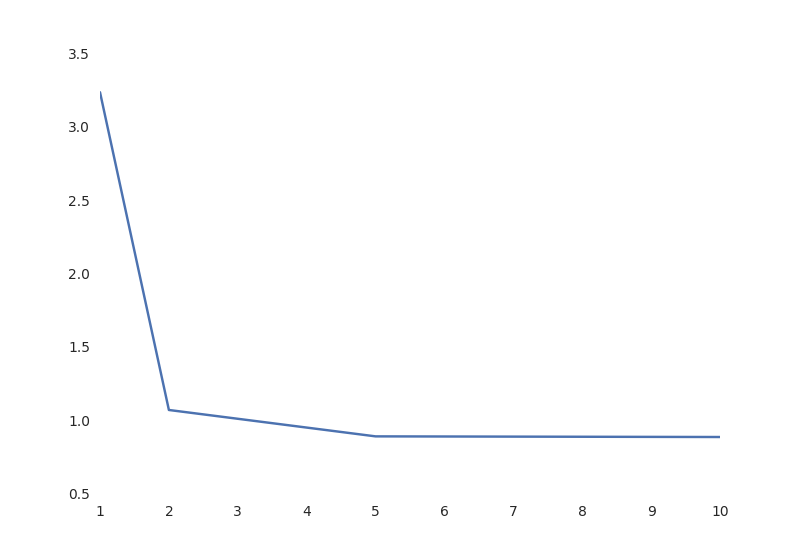

In [37]:
iter_array = [1, 2, 5, 10]
plot_learning_curve(iter_array, train, validation, 0.2, 10)

# write your function to plot the learning curve 

### Part 4: Model testing
And finally, make a prediction and check the testing error.

In [39]:
test_for_predict = test.map(lambda x: (x[0], x[1]))

predictions = final_model.predictAll(test_for_predict).map(lambda r: ((r[0], r[1]), r[2]))
rates_and_preds = test.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    
print ('For testing data the RMSE is %s' % (error))

For testing data the RMSE is 0.896914128248